# Running maps and pathway together

In [1]:
import numpy as np
import os
import geopandas
import pandas as pd

In [2]:
from classes.model import Model
from classes.scenario import Scenario
from stroke_maps.catchment import Catchment
from stroke_maps.combine import Combine
import stroke_maps.geo
import stroke_maps.plot
from stroke_maps.utils import convert_df_to_gdf

In [3]:
dir_output = os.path.join('output', 'everything')

# Temporary rubbish dir extender to prevent overwriting:
while os.path.exists(dir_output):
    dir_output += '1'

os.mkdir(dir_output)

In [4]:
merge_dicts = dict(
    df_units_input = {},
    df_transfer = {},
    df_lsoa_input = {},
    df_selected_units_input = {},
    df_selected_transfer = {},
    df_selected_lsoa_input = {},
    df_lsoa = {},
    df_units = {},
    df_selected_units = {},
    df_selected_lsoa = {},
    results_summary_by_admitting_unit = {},
    results_summary_by_lsoa = {}
)

In [5]:
units_to_include = [
    'GL13NN',
    'SN36BB',
    'BS105NB',
    'EX314JB',
    'PL68DH',
    'TR13LQ',
    'EX25DW',
    'BA13NG',
    'SP28BJ',
    'TA15DA',
    'TQ27AA',
    'BS234TQ',
    'BA214AT',
]

In [6]:
combine = Combine()

## Scenario 1

In [7]:
scenario_name = 'drip-and-ship'

Set the unit services and find the LSOA catchment areas:

In [8]:
# Catchment overwrites default values
catchment = Catchment({
    # "setup": setup,
    'name': scenario_name,
    "run_duration": 5,  # years
})

df_units = catchment.get_unit_services()

df_units = df_units.reset_index()

mask = df_units['postcode'].isin(units_to_include)
df_units.loc[mask, 'selected'] = 1

df_units = df_units.set_index('postcode')

In [9]:
df_units[df_units['selected'] == 1]

,stroke_team,short_code,ssnap_name,use_ivt,use_mt,use_msu,transfer_unit_postcode,lsoa_code,region,region_code,region_type,country,icb,icb_code,isdn,selected
postcode,,,,,,,,,,,,,,,,
BA13NG,Royal United Hospital Bath,BA,Royal United Hospital Bath,1,0,0,nearest,E01014428,"NHS Bath and North East Somerset, Swindon and ...",E38000231,SICBL,England,"NHS Bath and North East Somerset, Swindon and ...",E54000040,"Gloucester, BSW, BNSSG and Somerset",1
EX314JB,"North Devon District Hospital, Barnstaple",BP,North Devon District Hospital,1,0,0,nearest,E01020134,NHS Devon ICB - 15N,E38000230,SICBL,England,NHS Devon Integrated Care Board,E54000037,"Devon, Cornwall and Isles of Scilly",1
PL68DH,"Derriford Hospital, Plymouth",DF,Derriford Hospital,1,1,1,nearest,E01015092,NHS Devon ICB - 15N,E38000230,SICBL,England,NHS Devon Integrated Care Board,E54000037,"Devon, Cornwall and Isles of Scilly",1
EX25DW,Royal Devon and Exeter Hospital,EX,Royal Devon and Exeter Hospital,1,0,0,nearest,E01020013,NHS Devon ICB - 15N,E38000230,SICBL,England,NHS Devon Integrated Care Board,E54000037,"Devon, Cornwall and Isles of Scilly",1
GL13NN,"Gloucestershire Royal Hospital, Gloucester",GL,Gloucestershire Royal Hospital,1,0,0,nearest,E01022311,NHS Gloucestershire ICB - 11M,E38000062,SICBL,England,NHS Gloucestershire Integrated Care Board,E54000043,"Gloucester, BSW, BNSSG and Somerset",1
SN36BB,"Great Western Hospital, Swindon",GW,Great Western Hospital Swindon,1,0,0,nearest,E01015583,"NHS Bath and North East Somerset, Swindon and ...",E38000231,SICBL,England,"NHS Bath and North East Somerset, Swindon and ...",E54000040,"Gloucester, BSW, BNSSG and Somerset",1
TA15DA,"Musgrove Park Hospital, Taunton",MP,Musgrove Park Hospital,1,0,0,nearest,E01029302,NHS Somerset ICB - 11X,E38000150,SICBL,England,NHS Somerset Integrated Care Board,E54000038,"Gloucester, BSW, BNSSG and Somerset",1
BS105NB,North Bristol Hospital (Southmead),NB,North Bristol Hospitals,1,1,1,nearest,E01014631,"NHS Bristol, North Somerset and South Gloucest...",E38000222,SICBL,England,"NHS Bristol, North Somerset and South Gloucest...",E54000039,"Gloucester, BSW, BNSSG and Somerset",1
SP28BJ,Salisbury District Hospital,SS,Salisbury District Hospital,1,0,0,nearest,E01032000,"NHS Bath and North East Somerset, Swindon and ...",E38000231,SICBL,England,"NHS Bath and North East Somerset, Swindon and ...",E54000040,"Gloucester, BSW, BNSSG and Somerset",1


In [10]:
dict_useful_data = catchment.main(df_units)

Run the pathway:

In [11]:
scenario_simpy = Scenario(
    dict_useful_data['df_units'],
    dict_useful_data['df_transfer'],
    dict_useful_data['df_lsoa'],
)

model = Model(scenario_simpy)

model.run()

Combine input and output data:

In [12]:
df_input = dict_useful_data['df_lsoa'].copy()
df_results = model.results_summary_by_lsoa.copy()

df_input = df_input.reset_index()
df_input = df_input.set_index(df_results.index.names)

df_lsoa = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [13]:
df_input = scenario_simpy.df_selected_lsoa.copy()
df_results = model.results_summary_by_lsoa.copy()

df_input = df_input.reset_index()
df_input = df_input.set_index(df_results.index.names)

df_selected_lsoa = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [14]:
df_input = dict_useful_data['df_units'].copy()
df_results = model.results_summary_by_admitting_unit.copy()

df_results = df_results.reset_index()
df_results = df_results.rename(columns={'unit': 'postcode'})
df_results = df_results.set_index(df_input.index.names)

df_units = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [15]:
df_input = scenario_simpy.df_selected_units.copy()
df_results = model.results_summary_by_admitting_unit.copy()

df_results = df_results.reset_index()
df_results = df_results.rename(columns={'unit': 'postcode'})
df_results = df_results.set_index(df_input.index.names)

df_selected_units = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

Gather data for later combination:

In [16]:
# Update big dictionary of Dataframes:
merge_dicts['df_units_input'][scenario_name] = dict_useful_data['df_units']
merge_dicts['df_transfer'][scenario_name] = dict_useful_data['df_transfer']
merge_dicts['df_lsoa_input'][scenario_name] = dict_useful_data['df_lsoa']
merge_dicts['df_selected_units_input'][scenario_name] = scenario_simpy.df_selected_units
merge_dicts['df_selected_transfer'][scenario_name] = scenario_simpy.df_selected_transfer
merge_dicts['df_selected_lsoa_input'][scenario_name] = scenario_simpy.df_selected_lsoa
merge_dicts['results_summary_by_admitting_unit'][scenario_name] = model.results_summary_by_admitting_unit
merge_dicts['results_summary_by_lsoa'][scenario_name] = model.results_summary_by_lsoa
merge_dicts['df_lsoa'][scenario_name] = df_lsoa
merge_dicts['df_units'][scenario_name] = df_units
merge_dicts['df_selected_lsoa'][scenario_name] = df_selected_lsoa
merge_dicts['df_selected_units'][scenario_name] = df_selected_units

Save data to file:

In [17]:
dir_output_scenario = os.path.join(dir_output, scenario_name)

if os.path.exists(dir_output_scenario):
    pass
else:
    os.mkdir(dir_output_scenario)

In [18]:
file_dict = {
    'df_units_input': {
        'file': 'df_units_input.csv',
        'data': dict_useful_data['df_units']
    },
    'df_transfer': {
        'file': 'df_transfer.csv',
        'data': dict_useful_data['df_transfer']
    },
    'df_lsoa_input': {
        'file': 'df_lsoa_input.csv',
        'data': dict_useful_data['df_lsoa']
    },
    'df_selected_units_input': {
        'file': 'df_selected_units_input.csv',
        'data': scenario_simpy.df_selected_units
    },
    'df_selected_transfer': {
        'file': 'df_selected_transfer.csv',
        'data': scenario_simpy.df_selected_transfer
    },
    'df_selected_lsoa_input': {
        'file': 'df_selected_lsoa_input.csv',
        'data': scenario_simpy.df_selected_lsoa
    },
    'results_summary_by_admitting_unit': {
        'file': 'results_summary_by_admitting_unit.csv',
        'data': model.results_summary_by_admitting_unit
    },
    'results_summary_by_lsoa': {
        'file': 'results_summary_by_lsoa.csv',
        'data': model.results_summary_by_lsoa
    },
    'df_units': {
        'file': 'df_units.csv',
        'data': merge_dicts['df_units'][scenario_name]
    },
    'df_lsoa': {
        'file': 'df_lsoa.csv',
        'data': merge_dicts['df_lsoa'][scenario_name]
    },
    'df_selected_units': {
        'file': 'df_selected_units.csv',
        'data': merge_dicts['df_selected_units'][scenario_name]
    },
    'df_selected_lsoa': {
        'file': 'df_selected_lsoa.csv',
        'data': merge_dicts['df_selected_lsoa'][scenario_name]
    },
}

In [19]:
for data_type, data_dict in file_dict.items():
    path_to_file = os.path.join(dir_output_scenario, data_dict['file'])
    data_dict['data'].to_csv(path_to_file)

## Scenario 2

In [20]:
scenario_name = 'mothership'

Set the unit services and find the LSOA catchment areas:

In [21]:
# Catchment overwrites default values
catchment = Catchment({
    # "setup": setup,
    'name': scenario_name,
    "run_duration": 5,  # years
})

df_units = catchment.get_unit_services()

df_units = df_units.reset_index()

# Set all non-MT units to have no IVT:
mask = df_units['use_mt'] == 0
df_units.loc[mask, 'use_ivt'] = 0

mask = (
    (df_units['postcode'].isin(units_to_include)) &
    (df_units['use_ivt'] == 1)
)
df_units.loc[mask, 'selected'] = 1


df_units = df_units.set_index('postcode')

In [22]:
df_units[df_units['selected'] == 1]

,stroke_team,short_code,ssnap_name,use_ivt,use_mt,use_msu,transfer_unit_postcode,lsoa_code,region,region_code,region_type,country,icb,icb_code,isdn,selected
postcode,,,,,,,,,,,,,,,,
PL68DH,"Derriford Hospital, Plymouth",DF,Derriford Hospital,1,1,1,nearest,E01015092,NHS Devon ICB - 15N,E38000230,SICBL,England,NHS Devon Integrated Care Board,E54000037,"Devon, Cornwall and Isles of Scilly",1
BS105NB,North Bristol Hospital (Southmead),NB,North Bristol Hospitals,1,1,1,nearest,E01014631,"NHS Bristol, North Somerset and South Gloucest...",E38000222,SICBL,England,"NHS Bristol, North Somerset and South Gloucest...",E54000039,"Gloucester, BSW, BNSSG and Somerset",1


In [23]:
dict_useful_data['df_transfer']

,transfer_unit_travel_time,transfer_unit_postcode,selected
postcode,,,
SY231ER,135.8,CF144XW,0
CB20QQ,0.0,CB20QQ,0
L97AL,0.0,L97AL,0
CH495PE,27.3,L97AL,0
BA13NG,33.7,BS105NB,1
...,...,...,...
SL24HL,NaN,<NA>,0
HP112TT,34.8,OX39DU,0
BA214AT,74.5,BS105NB,1


In [24]:
dict_useful_data = catchment.main(df_units)

Run the pathway:

In [25]:
scenario_simpy = Scenario(
    dict_useful_data['df_units'],
    dict_useful_data['df_transfer'],
    dict_useful_data['df_lsoa'],
)

model = Model(scenario_simpy)

model.run()

Combine input and output data:

In [26]:
df_input = dict_useful_data['df_lsoa'].copy()
df_results = model.results_summary_by_lsoa.copy()

df_input = df_input.reset_index()
df_input = df_input.set_index(df_results.index.names)

df_lsoa = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [27]:
df_input = scenario_simpy.df_selected_lsoa.copy()
df_results = model.results_summary_by_lsoa.copy()

df_input = df_input.reset_index()
df_input = df_input.set_index(df_results.index.names)

df_selected_lsoa = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [28]:
df_input = dict_useful_data['df_units'].copy()
df_results = model.results_summary_by_admitting_unit.copy()

df_results = df_results.reset_index()
df_results = df_results.rename(columns={'unit': 'postcode'})
df_results = df_results.set_index(df_input.index.names)

df_units = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

In [29]:
df_input = scenario_simpy.df_selected_units.copy()
df_results = model.results_summary_by_admitting_unit.copy()

df_results = df_results.reset_index()
df_results = df_results.rename(columns={'unit': 'postcode'})
df_results = df_results.set_index(df_input.index.names)

df_selected_units = combine.combine_inputs_and_results(
    df_input, df_results, how='left')

Gather data for later combination:

In [30]:
# Update big dictionary of Dataframes:
merge_dicts['df_units_input'][scenario_name] = dict_useful_data['df_units']
merge_dicts['df_transfer'][scenario_name] = dict_useful_data['df_transfer']
merge_dicts['df_lsoa_input'][scenario_name] = dict_useful_data['df_lsoa']
merge_dicts['df_selected_units_input'][scenario_name] = scenario_simpy.df_selected_units
merge_dicts['df_selected_transfer'][scenario_name] = scenario_simpy.df_selected_transfer
merge_dicts['df_selected_lsoa_input'][scenario_name] = scenario_simpy.df_selected_lsoa
merge_dicts['results_summary_by_admitting_unit'][scenario_name] = model.results_summary_by_admitting_unit
merge_dicts['results_summary_by_lsoa'][scenario_name] = model.results_summary_by_lsoa
merge_dicts['df_lsoa'][scenario_name] = df_lsoa
merge_dicts['df_units'][scenario_name] = df_units
merge_dicts['df_selected_lsoa'][scenario_name] = df_selected_lsoa
merge_dicts['df_selected_units'][scenario_name] = df_selected_units

Save data to file:

In [31]:
dir_output_scenario = os.path.join(dir_output, scenario_name)

if os.path.exists(dir_output_scenario):
    pass
else:
    os.mkdir(dir_output_scenario)

In [32]:
file_dict = {
    'df_units_input': {
        'file': 'df_units_input.csv',
        'data': dict_useful_data['df_units']
    },
    'df_transfer': {
        'file': 'df_transfer.csv',
        'data': dict_useful_data['df_transfer']
    },
    'df_lsoa_input': {
        'file': 'df_lsoa_input.csv',
        'data': dict_useful_data['df_lsoa']
    },
    'df_selected_units_input': {
        'file': 'df_selected_units_input.csv',
        'data': scenario_simpy.df_selected_units
    },
    'df_selected_transfer': {
        'file': 'df_selected_transfer.csv',
        'data': scenario_simpy.df_selected_transfer
    },
    'df_selected_lsoa_input': {
        'file': 'df_selected_lsoa_input.csv',
        'data': scenario_simpy.df_selected_lsoa
    },
    'results_summary_by_admitting_unit': {
        'file': 'results_summary_by_admitting_unit.csv',
        'data': model.results_summary_by_admitting_unit
    },
    'results_summary_by_lsoa': {
        'file': 'results_summary_by_lsoa.csv',
        'data': model.results_summary_by_lsoa
    },
    'df_units': {
        'file': 'df_units.csv',
        'data': merge_dicts['df_units'][scenario_name]
    },
    'df_lsoa': {
        'file': 'df_lsoa.csv',
        'data': merge_dicts['df_lsoa'][scenario_name]
    },
    'df_selected_units': {
        'file': 'df_selected_units.csv',
        'data': merge_dicts['df_selected_units'][scenario_name]
    },
    'df_selected_lsoa': {
        'file': 'df_selected_lsoa.csv',
        'data': merge_dicts['df_selected_lsoa'][scenario_name]
    },
}

In [33]:
for data_type, data_dict in file_dict.items():
    path_to_file = os.path.join(dir_output_scenario, data_dict['file'])
    data_dict['data'].to_csv(path_to_file)

## Combine multiple scenarios

In [34]:
combo_df_units = combine.combine_units(
    merge_dicts['df_units'])

combo_df_transfer = combine.combine_transfer(
    merge_dicts['df_transfer'])

combo_df_lsoa = combine.combine_lsoa(
    merge_dicts['df_lsoa'])

combo_df_selected_units = combine.combine_units(
    merge_dicts['df_selected_units'])

combo_df_selected_transfer = combine.combine_transfer(
    merge_dicts['df_selected_transfer'])

combo_df_selected_lsoa = combine.combine_lsoa(
    merge_dicts['df_selected_lsoa'])

/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/stroke_maps/combine.py:470: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.copy().drop(cols_for_any, axis='columns')
/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/stroke_maps/combine.py:470: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.copy().drop(cols_for_any, axis='columns')


Save data to file:

In [35]:
dir_output_combined = os.path.join(dir_output, 'combined')

if os.path.exists(dir_output_combined):
    pass
else:
    os.mkdir(dir_output_combined)

In [36]:
file_dict = {
    'combo_df_units': {
        'file': 'df_units.csv',
        'data': combo_df_units,
    },
    'combo_df_transfer': {
        'file': 'df_transfer.csv',
        'data': combo_df_transfer,
    },
    'combo_df_lsoa': {
        'file': 'df_lsoa.csv',
        'data': combo_df_lsoa,
    },
    'combo_df_selected_units': {
        'file': 'df_selected_units.csv',
        'data': combo_df_selected_units, 
    },
    'combo_df_selected_transfer': {
        'file': 'df_selected_transfer.csv',
        'data': combo_df_selected_transfer,
    },
    'combo_df_selected_lsoa': {
        'file': 'df_selected_lsoa.csv',
        'data': combo_df_selected_lsoa,
    }
}

In [37]:
for data_type, data_dict in file_dict.items():
    path_to_file = os.path.join(dir_output_combined, data_dict['file'])
    data_dict['data'].to_csv(path_to_file)

## Create geometry data

In [38]:
dir_geo = dir_output_combined

In [39]:
# Load in the data

combo_df_units = pd.read_csv(
    os.path.join(dir_geo, 'df_units.csv'),
    index_col=0,
    header=[0, 1, 2],
)
combo_df_transfer = pd.read_csv(
    os.path.join(dir_geo, 'df_transfer.csv'),
    index_col=[0, 1],
    header=[0, 1],
)
combo_df_lsoa = pd.read_csv(
    os.path.join(dir_geo, 'df_lsoa.csv'),
    index_col=[0, 1],
    header=[0, 1, 2],
)

In [40]:
(
    gdf_boundaries_regions,
    gdf_points_units,
    gdf_lines_transfer,
    gdf_boundaries_lsoa,
    gdf_boundaries_catchment
) = stroke_maps.geo.main(
    combo_df_lsoa, combo_df_units, df_transfer=combo_df_transfer
    )

/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/stroke_maps/geo.py:531: PerformanceWarning: indexing past lexsort depth may impact performance.
  mask_units = df_units[('periphery_unit', scenario)] == 1


Save data to file:

In [41]:
# Create a new maps/ dir for outputs.
dir_output_maps = os.path.join(dir_geo, 'maps')
try:
    os.mkdir(dir_output_maps)
except FileExistsError:
    # The directory already exists.
    pass

In [42]:
file_dict = {
    'gdf_boundaries_regions': {
        'file': 'gdf_boundaries_regions.csv',
        'data': gdf_boundaries_regions,
    },
    'gdf_points_units': {
        'file': 'gdf_points_units.csv',
        'data': gdf_points_units,
    },
    'gdf_lines_transfer': {
        'file': 'gdf_lines_transfer.csv',
        'data': gdf_lines_transfer,
    },
    'gdf_boundaries_lsoa': {
        'file': 'gdf_boundaries_lsoa.csv',
        'data': gdf_boundaries_lsoa, 
    },
    'gdf_boundaries_catchment': {
        'file': 'gdf_boundaries_catchment.csv',
        'data': gdf_boundaries_catchment,
    },
}

In [43]:
for data_type, data_dict in file_dict.items():
    path_to_file = os.path.join(dir_output_maps, data_dict['file'])
    data_dict['data'].to_csv(path_to_file)

## Setup for maps

Crop all geometry data to the same axis limits and assign colours to the catchment areas:

In [44]:
dir_maps = os.path.join(dir_geo, 'maps')

In [45]:
# Load in the data

gdf_boundaries_regions = pd.read_csv(
    os.path.join(dir_maps, 'gdf_boundaries_regions.csv'),
    index_col=[0],
    header=[0, 1],
)
gdf_points_units = pd.read_csv(
    os.path.join(dir_maps, 'gdf_points_units.csv'),
    index_col=[0],
    header=[0, 1, 2],
)
gdf_lines_transfer = pd.read_csv(
    os.path.join(dir_maps, 'gdf_lines_transfer.csv'),
    index_col=[0],
    header=[0, 1],
)
gdf_boundaries_lsoa = pd.read_csv(
    os.path.join(dir_maps, 'gdf_boundaries_lsoa.csv'),
    index_col=[0],
    header=[0, 1, 2],
)
gdf_boundaries_catchment = pd.read_csv(
    os.path.join(dir_maps, 'gdf_boundaries_catchment.csv'),
    index_col=[0],
    header=[0, 1],
)

In [46]:
gdf_boundaries_regions = convert_df_to_gdf(gdf_boundaries_regions)
gdf_points_units = convert_df_to_gdf(gdf_points_units)
gdf_lines_transfer = convert_df_to_gdf(gdf_lines_transfer)
gdf_boundaries_lsoa = convert_df_to_gdf(gdf_boundaries_lsoa)
gdf_boundaries_catchment = convert_df_to_gdf(gdf_boundaries_catchment)

In [47]:
(
gdf_boundaries_regions,
gdf_points_units,
gdf_boundaries_catchment,
gdf_boundaries_lsoa,
gdf_lines_transfer,
box_shared,
map_extent_shared
        ) = stroke_maps.plot.main(
    gdf_boundaries_regions,
    gdf_points_units,
    gdf_boundaries_catchment,
    gdf_boundaries_lsoa,
    gdf_lines_transfer,
    crop_axis_leeway=5000
    )

/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setit

## Plotting

Combining the scenarios earlier means that these maps share axis limits even though they contain different information for each scenario.

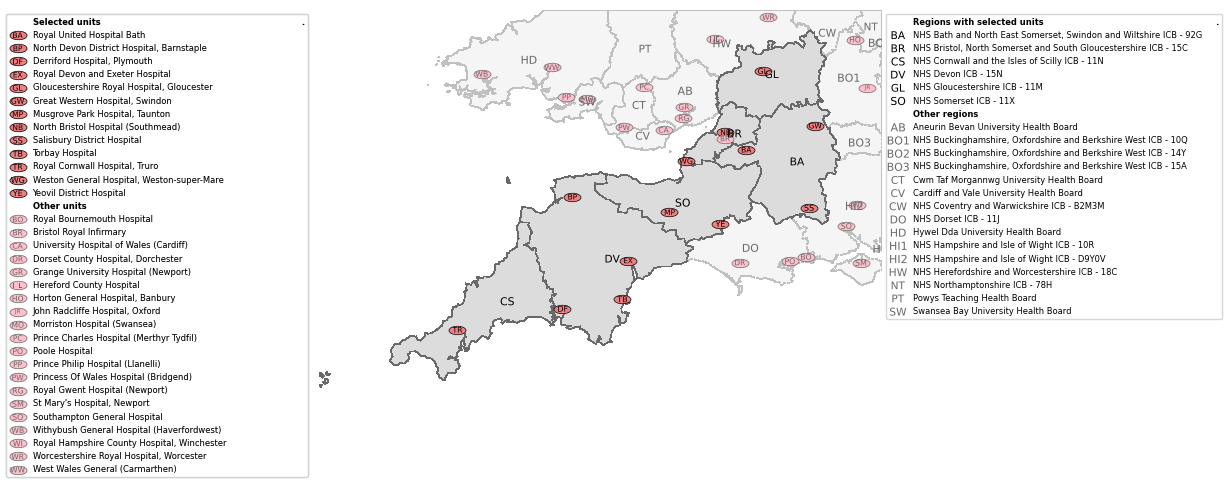

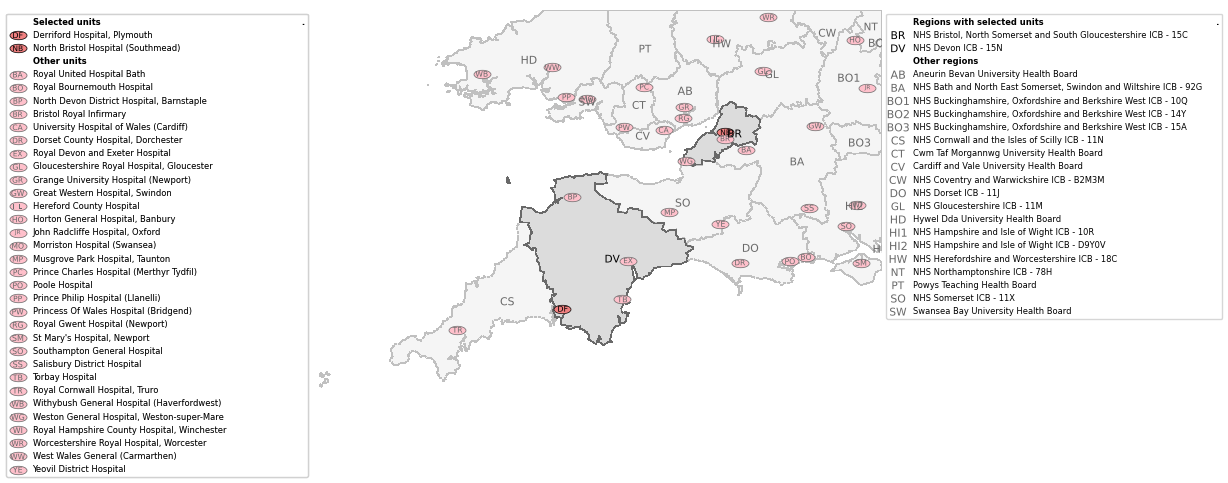

In [48]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_selected_regions(
        gdf_boundaries_regions,
        gdf_points_units,
        scenario=scenario,
        map_extent=map_extent_shared,
        path_to_file=os.path.join(dir_maps, f'map_regions_{scenario}.png')
    )

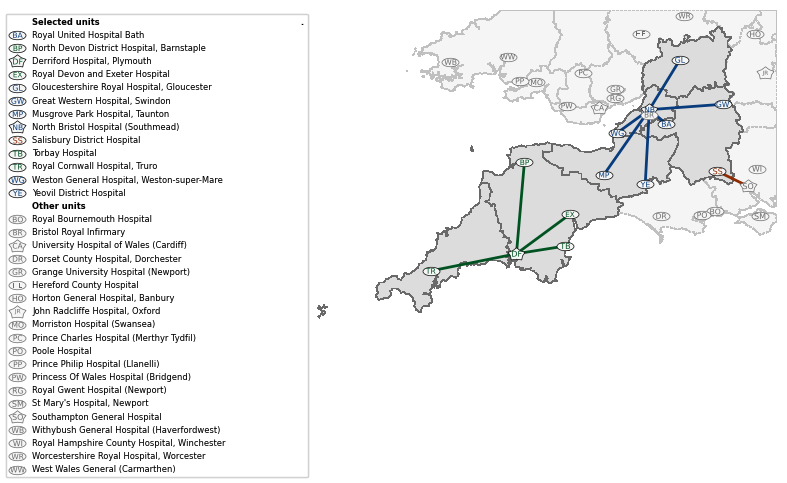

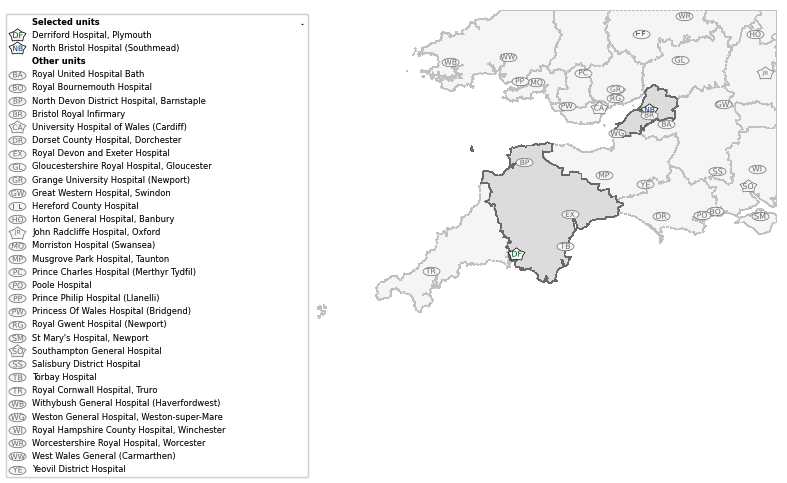

In [49]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_selected_units(
        gdf_boundaries_regions,
        gdf_points_units,
        gdf_lines_transfer,
        scenario=scenario,
        map_extent=map_extent_shared,
        path_to_file=os.path.join(dir_maps, f'map_units_{scenario}.png')
    )

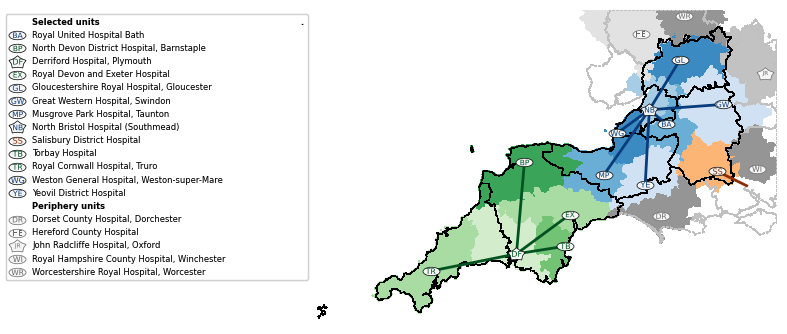

/home/anna/miniconda3/envs/simpy/lib/python3.10/site-packages/stroke_maps/plot_functions.py:278: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.plot(


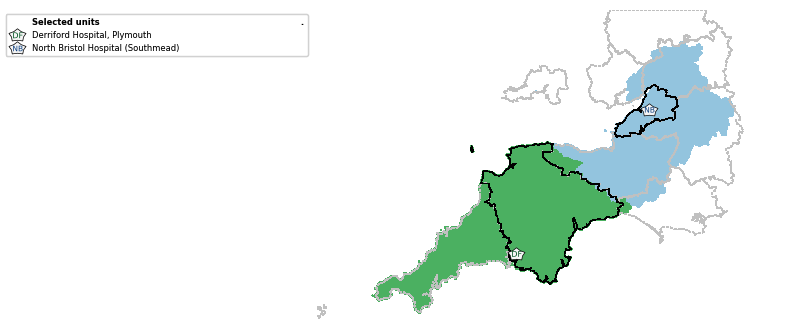

In [50]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_catchment(
        gdf_boundaries_catchment,
        gdf_boundaries_regions,
        gdf_points_units,
        gdf_lines_transfer,
        scenario=scenario,
        map_extent=map_extent_shared,
        path_to_file=os.path.join(dir_maps, f'map_catchment_{scenario}.png')
    )

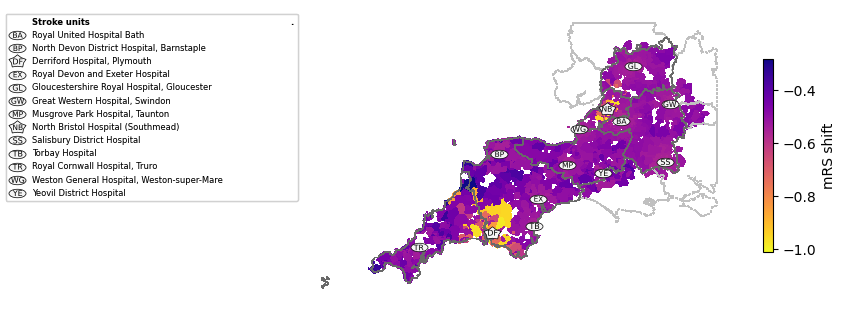

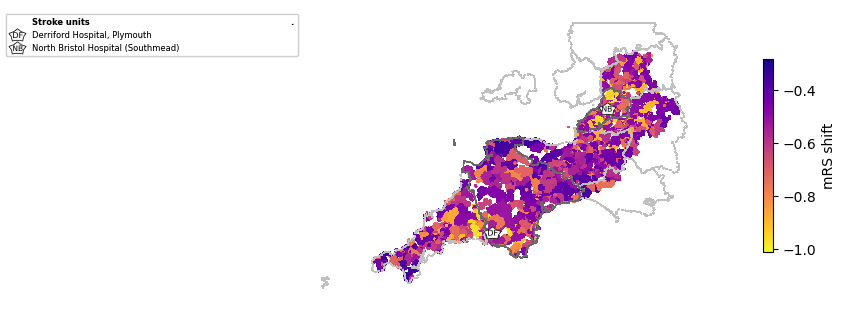

In [51]:
outcome = 'mRS shift'

for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_outcome(
        gdf_boundaries_lsoa,
        gdf_boundaries_regions,
        gdf_points_units,
        scenario=scenario,
        outcome=outcome,
        path_to_file=os.path.join(dir_maps, f'map_{outcome}_{scenario}.png')
    )

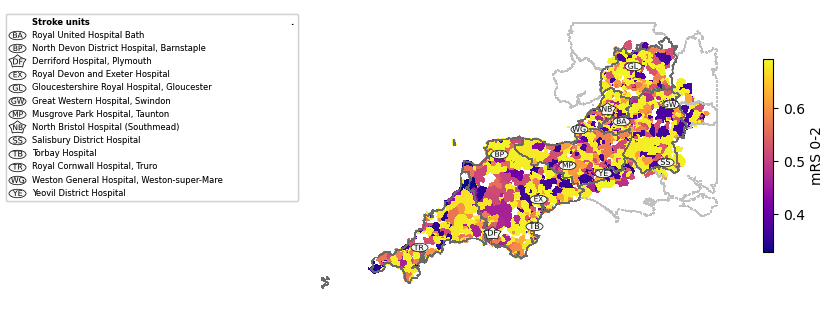

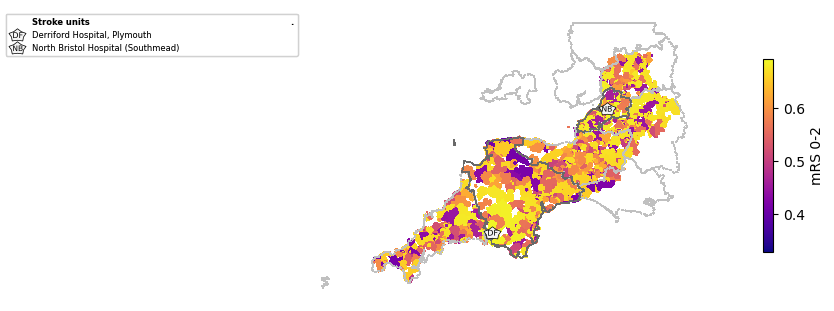

In [52]:
outcome = 'mRS 0-2'

for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_outcome(
        gdf_boundaries_lsoa,
        gdf_boundaries_regions,
        gdf_points_units,
        scenario=scenario,
        outcome=outcome,
        path_to_file=os.path.join(dir_maps, f'map_{outcome}_{scenario}.png')
    )

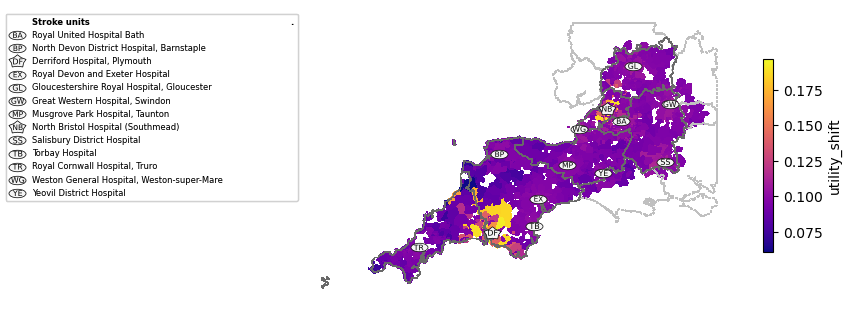

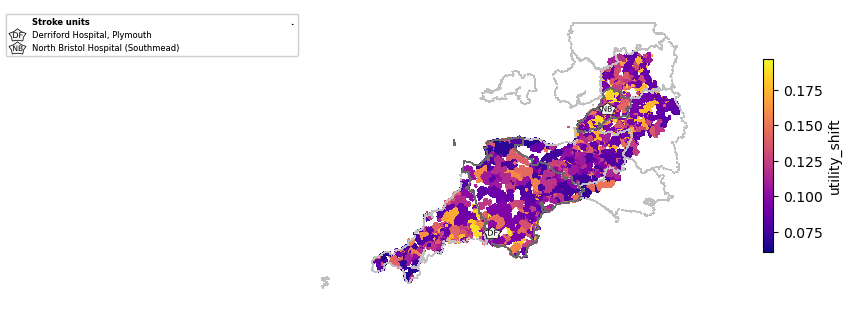

In [53]:
outcome = 'utility_shift'

for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_outcome(
        gdf_boundaries_lsoa,
        gdf_boundaries_regions,
        gdf_points_units,
        scenario=scenario,
        outcome=outcome,
        path_to_file=os.path.join(dir_maps, f'map_{outcome}_{scenario}.png')
    )